In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score

import joblib
# import shap

import warnings
warnings.filterwarnings('ignore')


In [115]:
data = pd.read_csv('API/df_pricing.csv')
data.head()

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
2,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
3,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183
4,Citroën,152352,225,petrol,black,convertible,True,True,False,False,True,True,True,131


In [116]:
data.shape

(4709, 14)

In [117]:
unvalid_models = ['Suzuki', 'Porsche', 'Ford', 'KIA Motors', 'Alfa Romeo', 'Fiat', 'Lexus', 'Lamborghini', 'Mini', 'Mazda', 'Honda', 'Yamaha']

In [118]:
to_drop = data['model_key'].isin(unvalid_models)
data = data[~to_drop]

In [119]:
#drop missing values
data = data.dropna()

In [120]:
data.shape

(4682, 14)

In [121]:
data['fuel'].value_counts()

diesel           4513
petrol            168
hybrid_petrol       1
Name: fuel, dtype: int64

In [122]:
#encode fuel type
data['fuel'] = data['fuel'].map({'diesel': 0, 'petrol': 1, 'hybrid_petrol': 2})

In [123]:
features_list = list(data.columns[:-1])
target_variable = 'rental_price_per_day'

X = data.loc[:, features_list]
Y = data.loc[:, target_variable]

In [124]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [125]:
numeric_features = []
categorical_features = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['mileage', 'engine_power', 'fuel']
Found categorical features  ['model_key', 'paint_color', 'car_type', 'private_parking_available', 'has_gps', 'has_air_conditioning', 'automatic_car', 'has_getaround_connect', 'has_speed_regulator', 'winter_tires']


In [126]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [127]:
linear = LinearRegression()
linear.fit(X_train, Y_train)

train_pred = linear.predict(X_train)
test_pred = linear.predict(X_test)

print("f1-score on train set : ", r2_score(Y_train, train_pred))
print("f1-score on test set : ", r2_score(Y_test, test_pred))

f1-score on train set :  0.7150310265217498
f1-score on test set :  0.6688418484242709


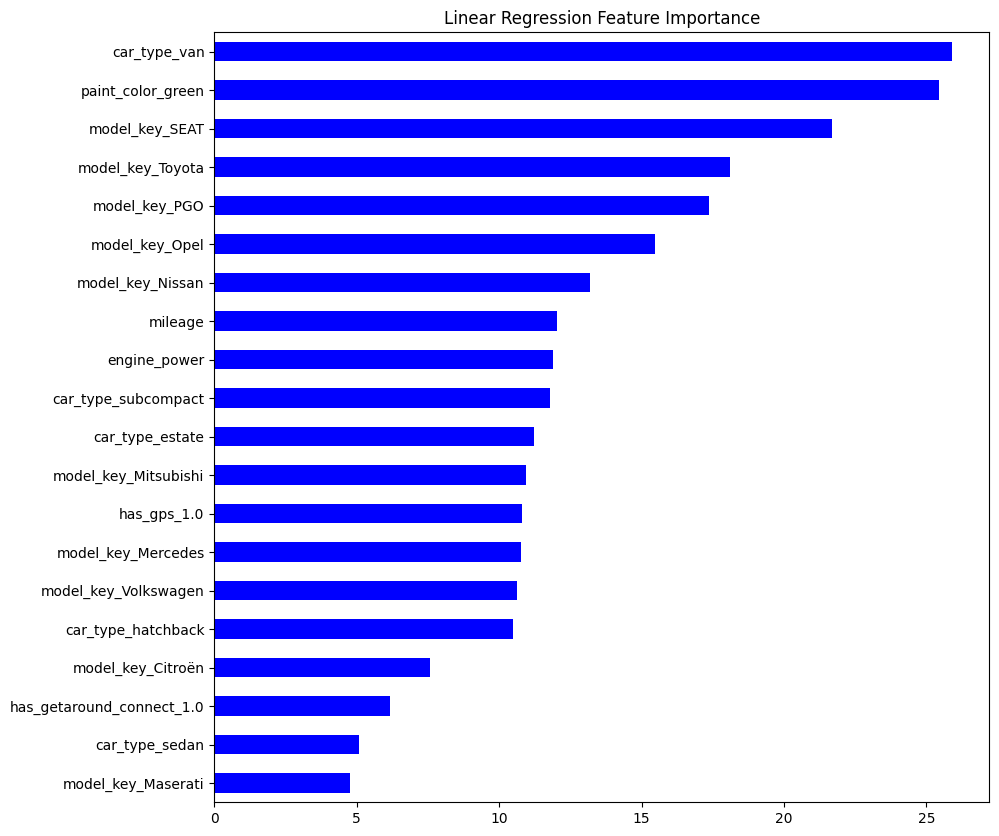

In [143]:
col_names = list(preprocessor.transformers_[0][1].get_feature_names_out()) + list(preprocessor.transformers_[1][1].get_feature_names_out())
feat_importances = pd.Series(np.abs(linear.coef_), index=col_names).sort_values(ascending=False)[:20]
plt.figure(figsize=(10,10))
feat_importances.sort_values().plot(kind='barh', color='blue')
plt.title('Linear Regression Feature Importance')
plt.show() 

In [146]:
from sklearn.model_selection import GridSearchCV

gbr = GradientBoostingRegressor()
params = {
    'learning_rate': [0.1,0.05,0.2],
    'max_leaf_nodes': [20,30,40,50,60],
    'max_depth' : [6,8,10,12,16],
    'min_samples_leaf' : [2,4,6,8,10],
    'n_estimators' : [75,100,125,150]
}

gridsearch = GridSearchCV(gbr, param_grid = params, n_jobs=-1, cv = 7,scoring='r2') 
gridsearch.fit(X_train, Y_train)
print("Best: %f using %s" % (gridsearch.best_score_, gridsearch.best_params_))

Best: 0.783232 using {'learning_rate': 0.1, 'max_depth': 12, 'max_leaf_nodes': 30, 'min_samples_leaf': 2, 'n_estimators': 150}


In [147]:
gbr = GradientBoostingRegressor(learning_rate= 0.1, max_depth= 12, max_leaf_nodes= 30, min_samples_leaf= 2, n_estimators= 150)
gbr.fit(X_train, Y_train)

train_pred = gbr.predict(X_train)
test_pred = gbr.predict(X_test)

print("f1-score on train set : ", r2_score(Y_train, train_pred))
print("f1-score on test set : ", r2_score(Y_test, test_pred))

f1-score on train set :  0.9217833937778954
f1-score on test set :  0.7482945569617736


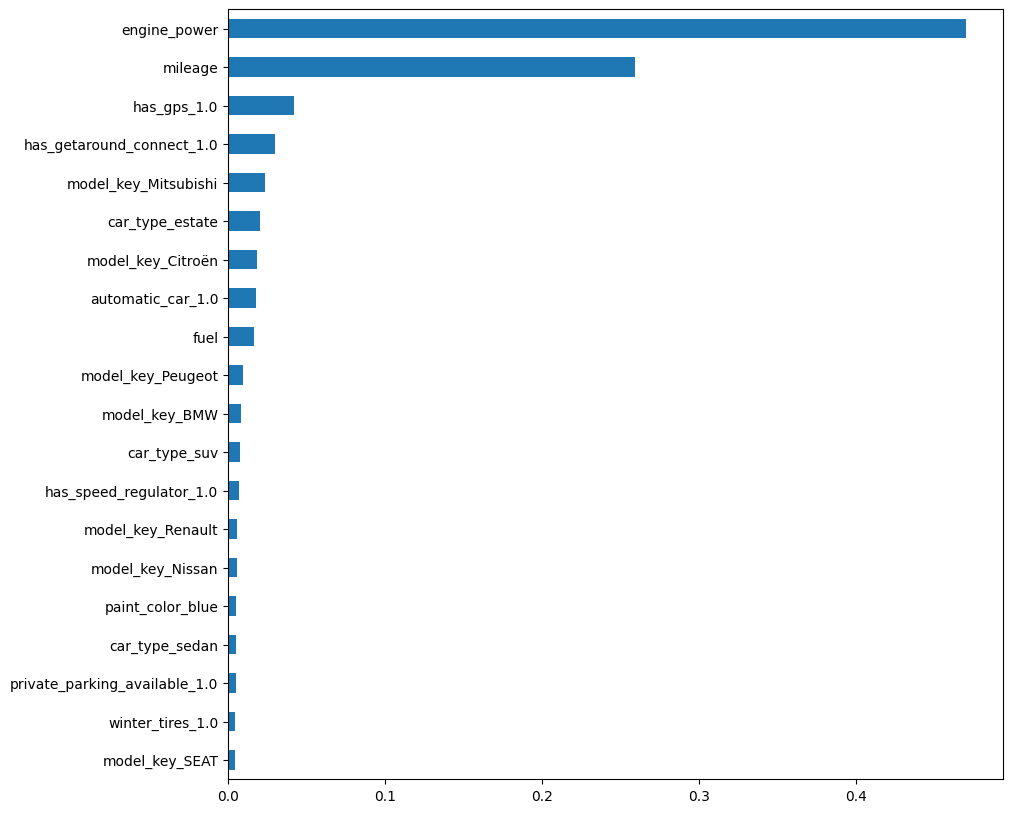

In [148]:
col_names = list(preprocessor.transformers_[0][1].get_feature_names_out()) + list(preprocessor.transformers_[1][1].get_feature_names_out())
feat_importances = pd.Series(gbr.feature_importances_, index=col_names).sort_values(ascending=False)[:20] # limiting to 20 features
plt.figure(figsize=(10,10))
feat_importances.sort_values().plot(kind='barh')
plt.show()

# Setting up an API

In [149]:
joblib.dump(gbr,'API/gbr_model.pkl')
joblib.dump(preprocessor,'API/preprocessor.pkl')

['API/preprocessor.pkl']

In [155]:
predictionFeatures = {
                        "model_key" : "Peugeot",
                        "mileage" : 14699,
                        "engine_power" : 100,
                        "fuel" : 0,
                        "paint_color" : "black",
                        "car_type" : "sedan",
                        "private_parking_available" : False,
                        "has_gps" : True,
                        "has_air_conditioning" : False,
                        "automatic_car" : False,
                        "has_getaround_connect" : False,
                        "has_speed_regulator" : True,
                        "winter_tires" : True
                        }

In [156]:
df_input = pd.DataFrame(columns=list(predictionFeatures.keys()))
df_input.loc[0] = list(predictionFeatures.values())


In [157]:
X = df_input
X = preprocessor.transform(X)

pred = gbr.predict(X)
print('Prediction for rental price per day : ', pred[0],'$')

Prediction for rental price per day :  140.977348124938 $


The Pipeline of the API seems to be working, let's build the API.

In [159]:
import requests

url = 'http://localhost:8000/predict'

In [158]:
request_pred = requests.post(
                            url,
                            json={ "model_key": "Ford",
                                    "mileage": 50000, 
                                    "engine_power": 115, 
                                    "fuel": "diesel", 
                                    "paint_color": "blue", 
                                    "car_type": "convertible", 
                                    "private_parking_available": True, 
                                    "has_gps": True, 
                                    "has_air_conditioning": True, 
                                    "automatic_car": False, 
                                    "has_getaround_connect": True, 
                                    "has_speed_regulator": True, 
                                    "winter_tires": False 
                                    }
                            )

print("---------------------")
print(f"Rental price prediction for this car : {round(request_pred.json()['prediction'],2)} $")

ConnectionError: HTTPConnectionPool(host='localhost', port=8000): Max retries exceeded with url: /predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x00000182C8203A90>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))